# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [126]:
import psycopg2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

con = psycopg2.connect (
    host = "dsstudents.skillbox.ru",
    port= 5432,
    dbname= "human_resources",
    user= "readonly",
    password= "6hajV34RTQfmxhS"
)
cur = con.cursor()   
con.commit()

In [119]:
# перед проверкой гипотез найдем общее количество человек по всем департаментам
sql = """
SELECT COUNT(hr_dataset.id),department
FROM public.hr_dataset
GROUP BY department;
"""
workers=pd.read_sql_query(sql, con)
workers

,count,department
0,208,Production
1,10,Admin Offices
2,50,IT/IS
3,1,Executive Office
4,10,Software Engineering
5,31,Sales


В департаменте Executive Office только 1 человек. Этот департамент из анализа можно исключить.

Гипотеза 1.  Есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.

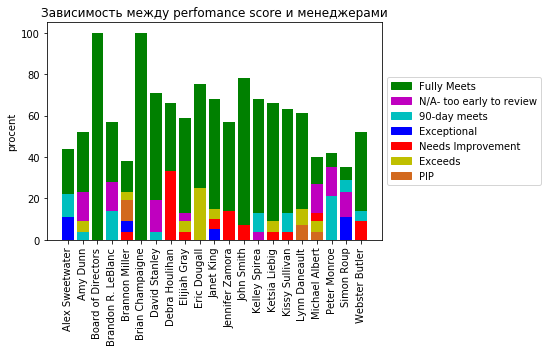

In [3]:
# рассмотрим общую статистику производительности работников по каждому менеджеру  
# в процентах от общего числа работников менеджеров
sql = """
SELECT v1."Manager Name" AS Manager_Name, v2.COUNT*100/v1.sum_wokers AS procent,v2."Performance Score" 
AS Performance_Score
FROM
(SELECT COUNT(hr_dataset.id) AS sum_wokers, hr_dataset."Manager Name"
FROM public.hr_dataset 
WHERE "Manager Name"!='None'
GROUP BY "Manager Name") as v1
LEFT JOIN
(SELECT COUNT (hr_dataset.id) AS COUNT, hr_dataset."Manager Name",hr_dataset."Performance Score"
FROM public.hr_dataset
WHERE "Manager Name"!='None'
GROUP BY "Manager Name","Performance Score") as v2
ON v1."Manager Name"=v2."Manager Name"
ORDER BY Manager_Name, procent DESC;
"""
# построим график
table=pd.read_sql_query(sql, con)
x = table.loc[:,'manager_name']
y = table.loc[:,'procent']
colors = {'Fully Meets':"green",'N/A- too early to review':"m","90-day meets":"c","Exceptional":"b",\
          'Needs Improvement': "r", 'Exceeds':"y", 'PIP': "chocolate" }        
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
K=table.loc[:,'performance_score'].map\
                   ({'Fully Meets':"green",'N/A- too early to review':"m","90-day meets":"c","Exceptional":"b",\
          'Needs Improvement': "r", 'Exceeds':"y", 'PIP': "chocolate" })
plt.bar(x, y, color=K)
plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('procent')
plt.title('Зависимость между perfomance score и менеджерами')
plt.xticks(rotation='vertical')
plt.show()

ВЫВОД.


 - Из графиков видно, что более 50% работников всех менеджеров полностью соответствует ожидаемой производительности. Все менеджеры  справляются со своей работой.
 - Исключение составляет, пожалуй,  Debra Houlihan. У нее больше,чем у других менеджеров, работников не соответствует оценке (33% от общего числа). Новых сотрудников  не стоит направлять к ней, т.к. процент Need Improvement может еще больше вырасти. 

Гипотеза 2. Зависимость между продолжительностью работы в компании и возрастом сотрудника по департаментам.

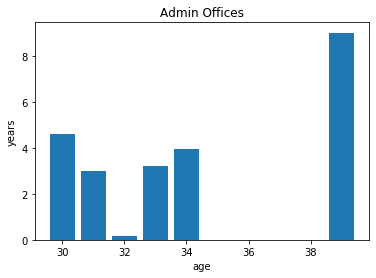

In [26]:
# найдем среднюю продолжтельность работы сотрудников по департменатам и построим для определения графики
sql = """
SELECT AVG("Days Employed")/360 as years, hr_dataset.age
FROM public.hr_dataset
WHERE department='Admin Offices'
GROUP BY  age
ORDER BY age
"""
Admin_Offices=pd.read_sql_query(sql, con)
plt.bar(Admin_Offices.loc[:,'age'],Admin_Offices.loc[:,'years'])
plt.ylabel('years')
plt.xlabel('age')
plt.title('Admin Offices')
plt.show()

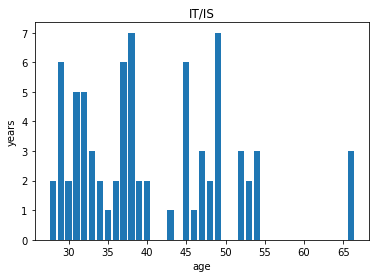

In [28]:
sql = """
SELECT "Days Employed"/360 as years, hr_dataset.age
FROM public.hr_dataset
WHERE department='IT/IS';
"""
IT=pd.read_sql_query(sql, con)
plt.bar(IT.loc[:,'age'],IT.loc[:,'years'])
plt.ylabel('years')
plt.xlabel('age')
plt.title('IT/IS')
plt.show()

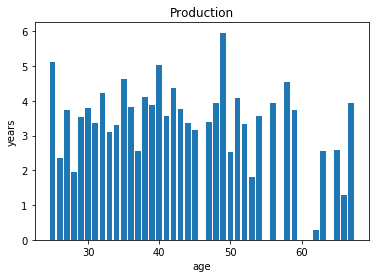

In [30]:
sql = """
SELECT AVG("Days Employed")/360 as years, hr_dataset.age
FROM public.hr_dataset
WHERE department='Production       '
GROUP BY hr_dataset.age;
"""
Production=pd.read_sql_query(sql, con)
plt.bar(Production.loc[:,'age'],Production.loc[:,'years'])
plt.ylabel('years')
plt.xlabel('age')
plt.title('Production')
plt.show()

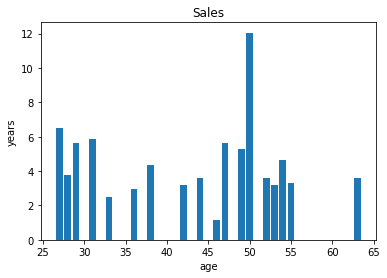

In [31]:
sql = """
SELECT AVG("Days Employed")/360 as years, hr_dataset.age
FROM public.hr_dataset
WHERE department='Sales'
GROUP BY hr_dataset.age;
"""
Sales=pd.read_sql_query(sql, con)
plt.bar(Sales.loc[:,'age'],Sales.loc[:,'years'])
plt.ylabel('years')
plt.xlabel('age')
plt.title('Sales')
plt.show()

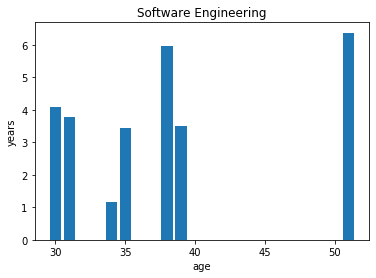

In [33]:
sql = """
SELECT AVG("Days Employed")/360 as years, hr_dataset.age
FROM public.hr_dataset
WHERE department='Software Engineering'
GROUP BY hr_dataset.age;
"""
Engineering=pd.read_sql_query(sql, con)
plt.bar(Engineering.loc[:,'age'],Engineering.loc[:,'years'])
plt.ylabel('years')
plt.xlabel('age')
plt.title('Software Engineering')
plt.show()

ВЫВОД.

Из графиков можно сделать выводы относительно возраста уже работающих в департаментах сотрудников :
 -  по департаменту Admin Offices:  Возраст сотрудников 30-40 лет, в среднем работают больше 3х лет.
 -  по департаментам IT/IS,Production, Sales: Возраст сотрудников от 25 лет до 67, в среднем работают больше 2х лет.
 -  по департаменту  Software Engineering: Возраст сотрудников от 30 лет до 55, в среднем работают больше 3х лет.
 

Гипотеза 3.
Есть зависимость между продолжительностью работы в компании и семейным положением, полом сотрудника по департаментам.

In [20]:
# определим зависимость между продолжительностью работы в компании и семейным положением.
# Примем, что marriedid=0- сотрудник без семьи, marriedid=1 - у сотрудника есть семья 
sql = """
SELECT hr_dataset.marriedid as marriedid , AVG("Days Employed")/360 as avg_years,department
FROM public.hr_dataset
GROUP BY hr_dataset.marriedid,department
ORDER BY department,avg_years;
"""
marriedid=pd.read_sql_query(sql, con)
marriedid

,marriedid,avg_years,department
0,0,3.253704,Admin Offices
1,1,4.243254,Admin Offices
2,1,5.480556,Executive Office
3,1,2.413889,IT/IS
4,0,2.994136,IT/IS
5,1,3.579549,Production
6,0,3.667057,Production
7,1,4.147500,Sales
8,0,4.674206,Sales
9,1,3.627778,Software Engineering


In [21]:
# определим зависимость между продолжительностью работы в компании и полом.
# Примем, что  genderid=0- женщина, genderid=1 - мужчина
sql = """
SELECT hr_dataset.genderid as genderid , AVG("Days Employed")/360 as avg_years,department
FROM public.hr_dataset
GROUP BY hr_dataset.genderid,department
ORDER BY department,avg_years;
"""
genderid=pd.read_sql_query(sql, con)
genderid

,genderid,avg_years,department
0,1,3.403472,Admin Offices
1,0,4.308333,Admin Offices
2,0,5.480556,Executive Office
3,1,2.454464,IT/IS
4,0,3.074369,IT/IS
5,0,3.604943,Production
6,1,3.678018,Production
7,0,4.298519,Sales
8,1,4.697222,Sales
9,1,3.718056,Software Engineering


ВЫВОД.

Из таблиц можно сделать  следующие выводы:
 -  по департаменту Admin Offices: В среднем дольше работают  замужние женщины, продолжительность работы в районе 4 лет. 
 -  по департаментам IT/IS, Production, Sales,Software Engineering : Семейное положение и пол на продолжительность работы не влияют. 

Гипотеза 4. Рассмотрим причины увольнения.

In [121]:
# Найдем количество людей, которое уволилось из каждого департамента за все время.
sql = """

SELECT COUNT(hr_dataset.id) AS count, department
FROM public.hr_dataset
WHERE "Date of Termination" is not null
GROUP BY department
ORDER BY count DESC;
"""
w=pd.read_sql_query(sql, con)
w

,count,department
0,83,Production
1,10,IT/IS
2,4,Sales
3,3,Admin Offices
4,3,Software Engineering


Как видим больше всего людей увольняется из Production. Это неудивительно,Production самый большой отдел в фирме.

In [122]:
# найдем самые популярные причины увольнения из production
sql = """

SELECT COUNT(production_staff.id) AS count, production_staff."Reason for Term","Position"
FROM public.production_staff
WHERE production_staff."TermDate"is not null
GROUP BY production_staff."Reason for Term","Position"
ORDER BY count DESC
LIMIT 5;
"""
t=pd.read_sql_query(sql, con)
t

,count,Reason for Term,Position
0,11,Another position,Production Technician I
1,7,more money,Production Technician I
2,7,unhappy,Production Technician I
3,6,unhappy,Production Technician II
4,4,Another position,Production Technician II


ВЫВОД.

Из таблицы можно сделать следующие выводы:
 - самые популярные причины увольнения из production: перевод на другую позицию, неудовлетворенность работой и неудовлетворенность зарплатой.
 -  большего всего увольняются Production Technician I по причине перевода на другую позицию.

Гипотеза 5. Есть зависимость между Employee Source и количеством найденных кандидатов.

In [127]:
# посчитаем cумму,которая была затрачена на поиски  работников, используя
# показатели из таблиц recruiting_costs и hr_dataset. Примем что итоговые затраты Total определены за 
# весь период существования фирмы.
sql = """
SELECT v1.count as workers, v2."Total",v2."Total"/v1.count as price_per_workers ,v2."Employment Source"
FROM 
(SELECT COUNT(hr_dataset.id) AS count, hr_dataset."Employee Source"
FROM public.hr_dataset
GROUP BY "Employee Source") as v1
JOIN 
(SELECT recruiting_costs."Total", recruiting_costs."Employment Source"
FROM public.recruiting_costs) as v2
ON v1."Employee Source"=v2."Employment Source"
ORDER BY workers,price_per_workers DESC;
"""
t=pd.read_sql_query(sql, con)
t

,workers,Total,price_per_workers,Employment Source
0,1,7790,7790,Careerbuilder
1,1,1323,1323,Pay Per Click
2,1,0,0,On-line Web application
3,1,0,0,Company Intranet - Partner
4,4,0,0,Information Session
5,6,0,0,Internet Search
6,9,3995,443,Other
7,11,5573,506,Social Networks - Facebook Twitter etc
8,12,7500,625,On-campus Recruiting
9,13,7143,549,Website Banner Ads


ВЫВОД.

Из таблицы можно сделать следующие выводы:
 -  наиболее эффективен способ  Employee Referral (на работу принят 31 человек). Для этого способа не нужны затраты.
 -  наименее эффективен способ Careerbuilder (на работу принят 1 человек). Для этого способа необходимо 7790 долларов.
 Для экономии средств фирмы лучше использовать способы On-line Web application, Company Intranet - Partner: также принят на работу 1 человек, но эти способы не требуют затрат.

In [128]:
cur.close()
con.close()

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

Я  обучаюсь на курсе последние полгода, поэтому взяла этот период для анализа. Хотелось бы посмотреть как изменилась активность, не упал ли интерес к курсам.    
P.S. Хотя Вконтакте сейчас не так популярен как раньше, телеграмм более показателен.

Для анализа вытащим из постов информацию для анализа: количество лайков репостов, комментов, время публикации, текст.


In [ ]:
# функция для отправлки JSON-запросы к API VK.

import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response


# access token не показываю для сохранения личных данных.
vk_token = '_________'

In [205]:
# функция для перевода даты в нужный формат
from datetime import datetime, timedelta
def good_data(L):
    New_spisok=[]
    for i in L:
        j=(datetime.fromtimestamp(i) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
        New_spisok.append(j)
    return (New_spisok)

In [207]:
# функция для анализа постов
import pandas as pd
def post(url):
    r=getjson(url)
#   список для добавления дат
    Data_def=[]
#   список для добавления количества лайков
    Likes_def=[]
#   список для добавления количества комментов
    Comments_def=[]
#   список для добавления количества репостов   
    Reposts_def=[]
#   список для добавления текста в посте
    Text_def=[]
    for i in range (0,100):
        Data_def.append(r['response'].get('items')[i].get('date'))
        Likes_def.append(r['response'].get('items')[i].get('likes').get('count'))
        Comments_def.append(r['response'].get('items')[i].get('comments').get('count'))
        Reposts_def.append(r['response'].get('items')[i].get('reposts').get('count'))
        Text_def.append(r['response'].get('items')[i].get('text'))
    Data_def=good_data(Data_def)
    
    df = pd.DataFrame({'data': Data_def, 'likes': Likes_def, 'comments': Comments_def,'reposts': Reposts_def,\
                       'text': Text_def})
    return df

url_1='https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=0&count=100&extended=1&v=5.92'
url_2= 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=100&count=100&extended=1&v=5.92'
url_3 = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=200&count=100&extended=1&v=5.92'  

In [208]:
new_df = pd.concat([post(url_1), post(url_2),post(url_3)],ignore_index=True)
#   добавим колонку год-месяц для удобства
new_df['Y_m']=pd.to_datetime(new_df['data']).map(lambda x: x.strftime('%Y-%m'))
#   добавим колонку с часами для удобства
new_df['H']=pd.to_datetime(new_df['data']).map(lambda x: x.strftime('%H'))
new_df

,data,likes,comments,reposts,text,Y_m,H
0,2020-03-26 11:31:12,18,6,1,"Где ваши классы, подарочки и открытки?\n\nСоци...",2020-03,11
1,2020-03-25 20:01:26,44,8,6,"«Нельзя быть уверенным, пригодится ли тебе это...",2020-03,20
2,2020-03-25 18:10:25,25,0,4,"У игры может быть устаревшая графика, предсказ...",2020-03,18
3,2020-03-25 13:26:14,56,4,3,«Как-то после лекции решил ради забавы попробо...,2020-03,13
4,2020-03-24 18:15:13,48,0,13,Дизайн-документ — краеугольный камень в разраб...,2020-03,18
...,...,...,...,...,...,...,...
295,2019-10-28 12:30:54,248,0,53,"Срочно нужна красивая презентация, но нет знак...",2019-10,12
296,2019-10-27 19:05:13,42,0,14,Customer Journey Map (CJM) — важный маркетинго...,2019-10,19
297,2019-10-26 13:10:00,13,18,0,Роботы уже готовятся заменить нас на рабочих м...,2019-10,13
298,2019-10-25 17:27:48,214,0,33,В 1985 году Стив Джобс покинул Apple и основал...,2019-10,17


К каждому посту добавлены хэштэги для удобства навигации.    
Последним в большинстве случаев стоит  тэг, относящийся к основному разделу (tag_main), а первым идет тэг, относящийся к подразделу основного раздела.   
Разобьем эти тэги по спискам: Last_tag - тэги основого раздела, First_tag - тэги подраздела.

In [209]:
import re
Last_tag=[]
First_tag=[]
#  выберем последние тэги из текста    
reg_expr_last = r'(#\w+$)'
#  выберем первые тэги из текста  
reg_expr_fist = r'(#\w+).#\w+'
reg_expr_compiled_last = re.compile(reg_expr_last)
reg_expr_compiled_fist = re.compile(reg_expr_fist)
for i in range (0,new_df.shape[0]):

    for g in reg_expr_compiled_last.findall(new_df.text.values[i]):
        Last_tag.append({i:g})
    for g in reg_expr_compiled_fist.findall(new_df.text.values[i]):
        First_tag.append({i:g})     

In [210]:
import itertools
#  создадим 2 датафрейма из списков и соединим их.  
Number_last = list(itertools.chain(*list([keys for keys,value in i.items()] for i in Last_tag)))
tag_last = list(itertools.chain(*list([value for keys,value in i.items()] for i in Last_tag)))
result_tag_last=pd.DataFrame({'Number':Number_last,'tag_main':tag_last})


Number_fist = list(itertools.chain(*list([keys for keys,value in i.items()] for i in First_tag)))
tag_fist = list(itertools.chain(*list([value for keys,value in i.items()] for i in First_tag)))
result_tag_first=pd.DataFrame({'Number':Number_fist,'tag_fist':tag_fist})

Result=pd.merge(result_tag_last, result_tag_first, how='left', left_on=['Number'],right_on=['Number'])
Result.set_index('Number', inplace = True)

# соединим итоговый датафрейм Result и исходный new_df
new=pd.merge(new_df,Result, how='left', left_index=True, right_index=True)
new.head(5)

,data,likes,comments,reposts,text,Y_m,H,tag_main,tag_fist
0,2020-03-26 11:31:12,18,6,1,"Где ваши классы, подарочки и открытки?\n\nСоци...",2020-03,11,#В_Закладки_Skillbox,NaN
1,2020-03-25 20:01:26,44,8,6,"«Нельзя быть уверенным, пригодится ли тебе это...",2020-03,20,#Подкаст_Skillbox,#Кант_поймет
2,2020-03-25 18:10:25,25,0,4,"У игры может быть устаревшая графика, предсказ...",2020-03,18,#Skillbox_программирование,#Статья_Skillbox
3,2020-03-25 13:26:14,56,4,3,«Как-то после лекции решил ради забавы попробо...,2020-03,13,#Skillbox_разработка,#Студенты_Skillbox
4,2020-03-24 18:15:13,48,0,13,Дизайн-документ — краеугольный камень в разраб...,2020-03,18,#Skillbox_программирование,#Статья_Skillbox


In [211]:
# определим посты с какими тэгами набирают в среднем наибольшую популярность

D=new.groupby(['tag_main','tag_fist']).agg({'likes':'mean','comments':'mean','reposts':'mean'}).reset_index()
print ()
print (D.loc[:,['tag_main','tag_fist','likes']].sort_values(['likes'],ascending=False).head(5))
print ()
print (D.loc[:,['tag_main','tag_fist','comments']].sort_values(['comments'],ascending=False).head(5))
print ()
print (D.loc[:,['tag_main','tag_fist','reposts']].sort_values(['reposts'],ascending=False).head(5))


                tag_main                 tag_fist  likes
13      #Skillbox_дизайн     #В_закладки_Skillbox  415.0
11      #Skillbox_дизайн       #Айдентик_Skillbox  393.0
34   #Skillbox_маркетинг     #В_закладки_Skillbox  351.2
6       #Skillbox_дизайн  #Cовет_препода_Skillbox  300.0
61  #В_закладки_Skillbox     #Skillbox_управление  267.0

                      tag_main                   tag_fist    comments
36         #Skillbox_маркетинг          #Задачка_Skillbox  120.000000
52        #Skillbox_управление             #Кейс_Skillbox   61.000000
7             #Skillbox_дизайн    #Design_Battle_Skillbox   42.666667
16            #Skillbox_дизайн  #Дизайн_упаковки_Skillbox   38.000000
44  #Skillbox_программирование          #Задачка_Skillbox   36.500000

                tag_main                 tag_fist  reposts
13      #Skillbox_дизайн     #В_закладки_Skillbox     80.5
6       #Skillbox_дизайн  #Cовет_препода_Skillbox     71.0
34   #Skillbox_маркетинг     #В_закладки_Skillbox     67.2

Выводы:
 -  Больше всего лайкают  и репостят посты в разделе Дизайн (подразделы Айдентик_Skillbox, В_закладки_Skillbox, Cовет_препода_Skillbox), Маркетинг (подраздел Skillbox_в_закладки).
 -  Больше всего комментируют посты в  разделе Маркетинг и Программирование (подраздел Задачка_Skillbox), Дизайн (разделы Design_Battle_Skillbox, Дизайн_упаковки_Skillbox).

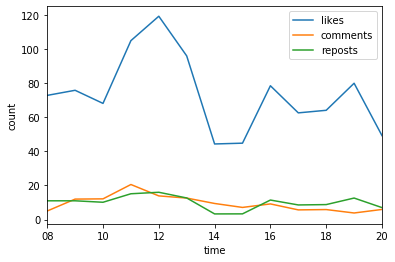

In [212]:
# посчитаем среднее количество лайков, комментариев и репостов относительно времени публикации постов и построим график
import matplotlib
import matplotlib.pyplot as plt
M=new.groupby('H').agg({'likes':'mean','comments':'mean','reposts':'mean'})
M.plot()
plt.ylabel('count')
plt.xlabel('time')
plt.show()

Время публикации не влияет сильно на количество репостов и комментариев, но влияет на лайки.   
Наилучшее время - с 11-13. В период с 14 до 15 активность наименьшая. 

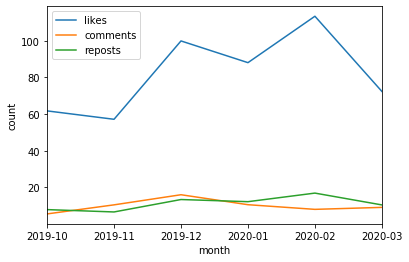

In [174]:
month=new_df.groupby('Y_m').agg({'likes':'mean','comments':'mean','reposts':'mean'})
month.plot()
plt.ylabel('count')
plt.xlabel('month')
plt.show()

Согласно графику активность идет волнами (подъем-спуск), интервалами примерно месяц-2 месяца.     
Могу предположить, что начало волны это старт акций.

Например, в ноябре были большие скидки на курсы, активность начала увеличиваться, затем спадать ,так как акция закончилась, приток студентов снзился. 